In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
import itertools
register_matplotlib_converters()

In [29]:
# set datetime index
df = pd.read_csv("Sprint_Resampled Data.csv")
df['Date'] = df['Date'].apply(pd.to_datetime)
df = df.set_index('Date')
df.columns
df = df["Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"]
df = df.dropna()
temp = df
df = temp[:int(0.95*(len(temp)))]
valid = temp[int(0.95*(len(temp))):]


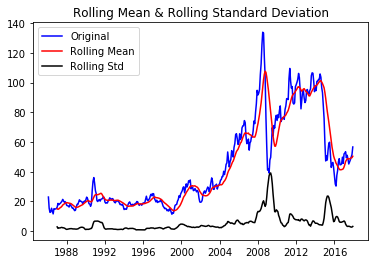

In [8]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [9]:
result = adfuller(df)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.6771266265464824
p-value: 0.4429343798104945
Critical Values:
	1%: -3.4478619826418817
	5%: -2.869257669826291
	10%: -2.570881358363513


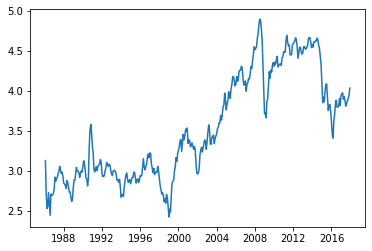

In [10]:
df_log = np.log(df)
plt.plot(df_log)

In [11]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

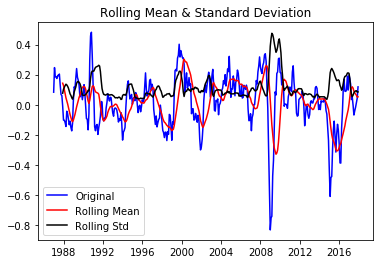

ADF Statistic: -6.771095105358584
p-value: 2.6406778719990133e-09
Critical Values:
	1%: -3.448196541708585
	5%: -2.869404683789669
	10%: -2.5709597356805545


In [12]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

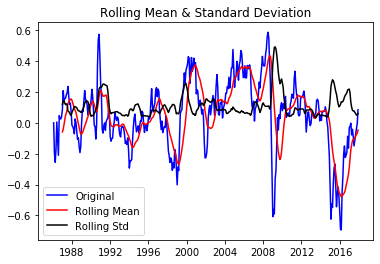

ADF Statistic: -4.892270578807191
p-value: 3.61028599498907e-05
Critical Values:
	1%: -3.4476305904172904
	5%: -2.869155980820355
	10%: -2.570827146203181


In [13]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

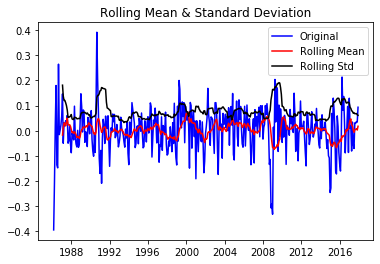

ADF Statistic: -15.154372773505237
p-value: 6.727083524920812e-28
Critical Values:
	1%: -3.4476305904172904
	5%: -2.869155980820355
	10%: -2.570827146203181


In [14]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [15]:
#TODO
orders = itertools.product((range(1,10)),(range(1,10)),range(1,10))


/home/yuntong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/yuntong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


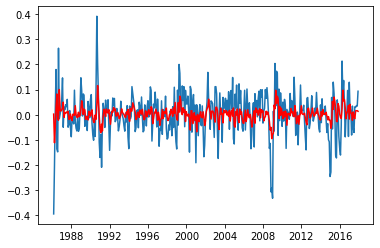

In [16]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

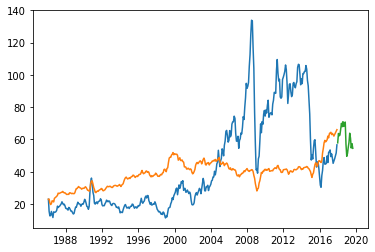

In [39]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=False)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)
plt.plot(valid)

In [18]:
results.predict(1,416)

1986-02-28    0.002593
1986-03-31   -0.111371
1986-04-30   -0.046806
1986-05-31    0.031405
1986-06-30    0.082808
1986-07-31   -0.013815
1986-08-31   -0.021621
1986-09-30    0.100424
1986-10-31    0.018108
1986-11-30    0.014770
1986-12-31    0.019038
1987-01-31    0.027479
1987-02-28    0.050064
1987-03-31   -0.010200
1987-04-30    0.009098
1987-05-31    0.006654
1987-06-30    0.011078
1987-07-31    0.007622
1987-08-31    0.014135
1987-09-30   -0.018554
1987-10-31   -0.015590
1987-11-30    0.002731
1987-12-31   -0.015008
1988-01-31   -0.023534
1988-02-29    0.002156
1988-03-31    0.001770
1988-04-30   -0.002112
1988-05-31    0.036094
1988-06-30    0.000381
1988-07-31   -0.009600
                ...   
2018-04-30   -0.005770
2018-05-31   -0.005067
2018-06-30   -0.003999
2018-07-31   -0.002895
2018-08-31   -0.001890
2018-09-30   -0.001029
2018-10-31   -0.000313
2018-11-30    0.000271
2018-12-31    0.000743
2019-01-31    0.001121
2019-02-28    0.001423
2019-03-31    0.001664
2019-04-30 

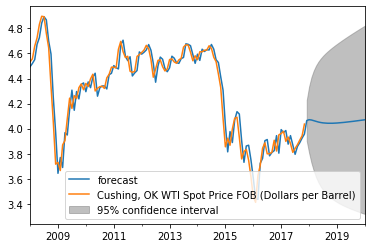

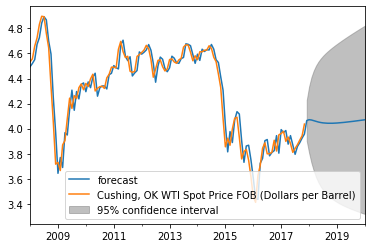

In [19]:
results.plot_predict("2008","2020")/